# FalconAI - Test 1 : Implementation du modèle dynamique brut

In [1]:
import numpy as np
import os 
import tqdm

In [2]:
def rotation(axis, angle):
    assert isinstance(axis, int) and 0<axis<4, 'only 3D rotations'
    
    angle = np.radians(angle)
    if axis==1:
        R = np.array(( (1, 0, 0),
                        (0, np.cos(angle), -np.sin(angle)),
                        (0, np.sin(angle),  np.cos(angle)) ))
    elif axis==2:
        R = np.array(((np.cos(angle), 0, np.sin(angle)),
                        (0, 1, 0),
                        (-np.sin(angle), 0,  np.cos(angle)) ))
    elif axis==3:
        R = np.array(((np.cos(angle), - np.sin(angle), 0),
                      (np.sin(angle), np.cos(angle), 0),
                      (0, 0, 1) ))
    return R 

In [3]:
def Poussee(alpha, beta, thr, T):
    """Calcul de la poussée du moteur principal dans le repère de la fusée
    alpha : rotation autour de x_f (en deg)
    beta : rotation autour de y_f (en deg)
    thr : throttle du moteur en %
    T : poussée nominale de la fusée (en N)
    """
    
    F = thr/100*np.array((0,0,T))
    F_f = np.dot(rotation(2, beta),np.dot(rotation(1, alpha), F))
    
    return(F_f)

In [4]:
def RPFD(F_f, D_f, I, m, X):
    """
    Calcul du Principe de Fondamental de la Dynamique 
    F_f : Poussée orientée du booster dans le repère de la fusée (en N)
    D_f : Vecteur point de poussée - CDG dans le repère de la fusée (en N)
    I : Inertie du booster autour de son CDG 
    m : masse du booster (en kg)
    X: vecteur état global
    """
    
    P = coord_local2global(np.array([[0, 0, -m*9.81]]), X)[0]
    #print('Poids dans ref fusée, {}'.format(P))
    x_pp = (F_f + P) / m
    
    M_f_CDG = np.cross(D_f, F_f)
    theta_pp = M_f_CDG / I
    #print('x_pp = {}'.format(x_pp))
    #print('theta_pp = {}'.format(theta_pp))
    #print(np.array([x_pp, theta_pp]))
    return np.array((x_pp, theta_pp))

In [5]:
def coord_local2global(vectors, state):
    """
    Recalcul des vecteurs dans le référentiel terrestre
    vectors : série de vecteurs dans le référentiel de la fusée
    state : état de la fusée dans les coordonnées du référentiel terrestre
    """
    assert vectors.shape[-1]==3, 'l`algo attend une suite de vecteurs 3D'
    
    alpha, beta, gamma = state[9:12, -1] * np.pi / 180
    
    #print('Dernier état de rotation , {}'.format(state[9:12, -1]))
    out=[]
    for vect in vectors:
        out.append(np.array(np.dot(rotation(3, gamma), np.dot(rotation(2, beta), np.dot(rotation(1, alpha), vect)))))
    return np.array(out)

In [6]:
def integration(X_s, dt, x_s):
    
    """
    Intégration temporelle de l'accélération direction et angulaire 
    X_s : vecteur d'état mémoire de la trajectoire (en unité SI : degrès et mêtres) 
        série de vecteurs colonnes position, vitesse, accélération de taille 3 
    dt : temps d'intégration (s)
    x_s : vecteur d'état de la fusée dans le référentiel global (acceleration, acceleration angulaire)
    """
    x_p = x_s[0] * dt + X_s[3:6, -1] 
    x = x_p * dt + X_s[0:3, -1]
    theta_p = x_s[1] * dt + X_s[12:15, -1]
    theta = theta_p * dt + X_s[9:12, -1]
    #print('theta_pp = {}'.format(x_s[1]))
    #print('x_p = {}'.format(x_p))
    #print('x = {}'.format(x))
    #print('theta_p = {}'.format(theta_p))
    #print('theta = {}'.format(theta))
    
    return np.c_[X_s, np.append(x, np.append(x_p, np.append(x_s[0], np.append(theta, np.append(theta_p, x_s[1])))))]

In [7]:
## test 1 
from IPython.display import clear_output

## Initialisation 
X = np.zeros((18, 1))
dt = 0.1
alpha = 0
beta = 0

# rocket characteristics
T = 8e6
thr=100
L = 70
r = 2.6
m_tot = 595000
I = np.array([ 1/12*m_tot*(3*r*r + L*L), 1/12*m_tot*(3*r*r + L*L), 1/2*m_tot*r*r])
# matrice d'inertie d'un cylindre 
D_f = np.array([0, 0, 35])
# Vecteur position de la poussée moteur au CDG de la fusée dans le repère de la fusée

for i in range(100):
    #print('iteration numero {}'.format(i))
    #print('last Xi : {}'.format(X[:, -1]))
    F_f = Poussee(alpha, beta, thr, T)
    #print('Poussée dans ref fusée, {}'.format(F_f))
    X_pp = RPFD(F_f, D_f, I, m_tot, X)
    #print('Vecteur Accel dans ref fusée, {}'.format(X_pp))
    X_pp = coord_local2global(X_pp, X)
    
    #print('Vecteur Accel dans ref global, {}'.format(X_pp))
    X = integration(X, dt, X_pp)
    
    if i==50:
        thr=80
        beta =30
    if i==25:
        alpha= 10
        
    if i<25:
        clear_output(wait=True)
        # https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code

In [8]:
#X.shape
X[:, -1]

array([ 6.48454901e+01, -5.89949384e+01,  1.28060055e+02,  2.59243722e+01,
       -1.49494897e+01,  1.48904639e+01,  5.27951626e+00, -1.85216873e+00,
       -6.47589090e-01,  5.04223754e+00,  5.53834449e+00,  2.43767259e-03,
        1.27949319e+00,  2.21533750e+00,  1.24405312e-03,  1.59438889e-01,
        4.52109430e-01,  4.18572126e-04])

In [9]:
#%matplotlib notebook
# https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

%matplotlib inline 
#https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

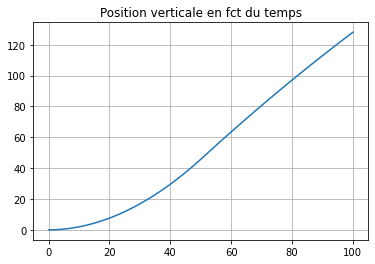

In [10]:
plt.plot(X[2, :])
plt.grid()
plt.title('Position verticale en fct du temps')
plt.show()

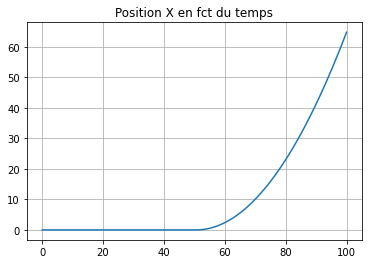

In [11]:
plt.plot(X[0, :])
plt.grid()
plt.title('Position X en fct du temps')
plt.show()

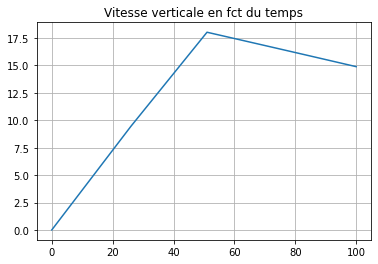

In [12]:
plt.plot(X[5, :])
plt.grid()
plt.title('Vitesse verticale en fct du temps')
plt.show()

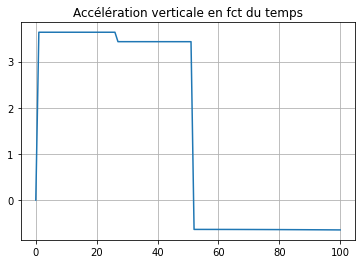

In [13]:
plt.plot(X[8, :])
plt.grid()
plt.title('Accélération verticale en fct du temps')
plt.show()

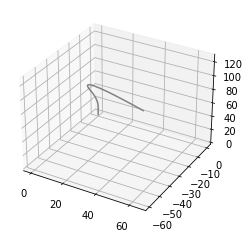

In [14]:
ax = plt.axes(projection='3d')
ax.plot3D(X[0, :], X[1, :], X[2, :], 'gray')

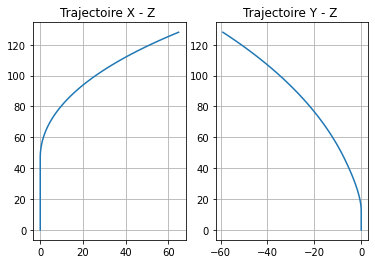

In [15]:
plt.subplot(121)
plt.plot(X[0, :], X[2, :])
plt.grid()
plt.title('Trajectoire X - Z ')
plt.subplot(122)
plt.plot(X[1, :], X[2, :])
plt.grid()
plt.title('Trajectoire Y - Z ')
plt.show()